In [1]:
import utils, shapely_utils as shu, python_utils as pu
import bezier
import numpy as  np
from shapely import LineString, MultiLineString, GeometryCollection
import shapely as sh

In [2]:
# imports
from pathlib import Path, PurePath
import sys

In [3]:

def bball_net(radius,m=0.15,n=0.25,total_slices=12,len_straight=4, prop_h=0.5):
    curve = bezier.Curve(np.asfortranarray(np.matrix([[0,0],[n/4,m],[n,prop_h*m]]).transpose()), degree=2)
    line = LineString([[-n/3,-n/len_straight],[0,0]])
    # return line
    l = sh.line_merge(MultiLineString([line,shu.curve_to_ls(curve)]))
    # return line
    a,b,c,d = l.bounds
    x_dist = c-a
    y_dist = d-b
    w_line,h_line = shu.size(line)
    
    p = sh.line_merge(MultiLineString([l,sh.affinity.translate(sh.affinity.scale(l, -1, 1),x_dist)]))
    # return l
    # return p
    w,h = shu.size(p)
    scale_prop = radius/w
    p = sh.affinity.scale(p, scale_prop, scale_prop)
    p2 = sh.affinity.translate(sh.affinity.scale(p, 1, -1),0,- h * scale_prop + h_line*scale_prop*2)
    lip = GeometryCollection([p,p2])
    # return lip
    # return lip
    # return lip
    tots_lips = []
    mergers_entre_lips = []
    def getLines(last_line, new_line):
        line = LineString([list(list(new_line.geoms)[1].coords)[0],list(list(last_line.geoms)[0].coords)[0]])
        line2 = LineString([list(list(new_line.geoms)[0].coords)[-1],list(list(last_line.geoms)[1].coords)[-1]])
        return [line, line2]
    first_line = None
    for i in range(int(total_slices/2)):
        new_line = sh.affinity.rotate(lip, i*(360/total_slices))
        if (i>0):
            mergers_entre_lips += getLines(last_line, new_line)
        else:
            first_line = new_line
        tots_lips.append(new_line)
        last_line = new_line
    # inverse
    line = LineString([list(list(first_line.geoms)[1].coords)[0],list(list(last_line.geoms)[1].coords)[-1]])
    line2 = LineString([list(list(first_line.geoms)[0].coords)[-1],list(list(last_line.geoms)[0].coords)[0]])
    mergers_entre_lips += [line, line2]
    # return tots_lips
    # print(len(tots_lips))
    # return [tots_lips,mergers_entre_lips]
    return shu.StructuredCollection(lips=tots_lips, lips_mergers=mergers_entre_lips)

In [4]:
pu.reload(shu)

In [5]:
pu.reload(shu)

In [ ]:
upB = bball_net(50, 0.15,0.25,10,3.7,0.85)
upB.geo
#si poso 10 tot palma

In [11]:
upB = bball_net(50, 0.15,0.25,10,3.7,0.85)
downB = bball_net(50, 0.15,0.25,10,3.7,0.85).translate(0,-100)
# downB2 = bball_net(50, 0.15,0.25,12,3.7,0.85).translate(0,90)
# shu.print([upB.geo, downB.geo])

In [ ]:
l2

In [ ]:
shu.get_quadrant(shu.first(l2),shu.last(l2))

In [ ]:
shu.last(l2)

In [ ]:
pu.reload(shu)

In [ ]:
shu.spring(l2,3,1,0.8)

In [22]:
top_mergers = 5
top_mergers_up = shu.reorder_geos(upB['lips_mergers'], "S", top_mergers)
top_mergers_down = shu.reorder_geos(downB['lips_mergers'], "N", top_mergers)
springs_top = []
springs_bottom = []
for i in range(top_mergers):
    l1 = top_mergers_up.geoms[i]
    spring_l1 = shu.spring(l1,3,1,0.8)
    springs_top.append(spring_l1)
    l2 = top_mergers_down.geoms[i]
    spring_l2 = shu.spring(l2,3,1,0.8)
    springs_bottom.append(spring_l2)

In [ ]:
l1

In [23]:
# shu.print([reorder_geos(upB['lips_mergers'], "E", 6),top_mergers_down])

In [24]:
# i = 0
# flow_total = []
# while (len(springs_bottom)>0 or len(springs_top)>0):
#     list_to_pick = springs_top
#     if i%2==1:
#         list_to_pick = springs_bottom
#     item = list_to_pick.pop()
#     flow_total.append(item)
#     i+=1

In [39]:
# last = None
# first_item = None
# guides = []
# for i,springs in enumerate(shu.iter_two(flow_total)):
#     s1, s2 = springs
#     if (not last is None):
#         guides.append(LineString([last, shu.first(s1)]))
#     guides.append(LineString([shu.last(s1), shu.first(s2)]))
#     last = shu.last(s2)
# last = None
first_item = None
guides = []
reorder_g = shu.reorder_geos(springs_top, "E")
for i,springs in enumerate(zip(shu.reorder_geos(springs_top, "E"), shu.reorder_geos(springs_bottom, "E"))):
    s1, s2 = springs
    # if (not last is None):
    guides.append(LineString([shu.first(s1), shu.last(s2)]))
    guides.append(LineString([shu.last(s1), shu.first(s2)]))
    # last = shu.last(s2)

In [40]:
springs_lip_merger = GeometryCollection([shu.spring(l,3,None,0.6) for l in shu.geoms(upB['lips_mergers'])])
# sh.affinity.scale(shu.print([springs_lip_merger, upB['lips_mergers']]),500,500)
# springs_lip_merger

In [41]:
# springs_lip_merger

In [42]:
# line = LineString([(0,1),(9,3)])
# shu.spring(line, 3,None,0.8)
# shu.print([shu.spring(line, 3, None,0.8)])

In [43]:
# x_off,y_off = line.bounds


In [44]:
def distribute_points(line, n_points):
    # TODO, not working in curved line!
    return [line.interpolate(line.length*(i/n_points)) for i in range(n_points)]
    all_coords = shu.coords(line.segmentize((line.length/n_points)))
    return all_coords

In [45]:
# shu.print(distribute_points(curv1,10)+[curv1])

In [46]:

def chunk_list(original_list, chunk_size=2):
    result = [original_list[i:i+chunk_size] for i in range(0, len(original_list), chunk_size)]
    return result

In [ ]:
# chunk_list([1,2,3,4,5])
shu.print(guides)

In [ ]:
import random
random.seed(10)
curves = []
right_lines = []
for j,g in enumerate(chunk_list(guides,2)):
    guide = g[1]
    if g[0].length>g[1].length:
        guide = g[0]
    segments = [LineString(l) for l in shu.iter_two(shu.coords(guide.segmentize(12)))]
    initial_coords = [shu.first(g[0]),shu.first(g[1])]
    last = None
    last_coords = [shu.last(g[0]),shu.last(g[1])]
    for i in range(len(segments)):
        segment = segments[i]
        centroid = segment.centroid
        norm1 = shu.sum_point_vector(centroid,shu.normal_vector(segment), total )
        c1 = shu.last(norm1)
        norm2 = shu.sum_point_vector(centroid,shu.normal_vector(segment), -total )
        c2 = shu.last(norm2)
        if (i==0):
            # LineSting(initial_coords[0], norm1, initial_coords[1], norm2, initial_coords[0])
            curve1 = shu.curved_path(initial_coords[0],shu.last(segment), c1, 1)
            curve2 = shu.curved_path(initial_coords[1],shu.last(segment), c2, 1)
            curves += [curve1, curve2]
        # else:   
        #     centroid = segments[i].centroid
        
        # # if (random.random()<0.75):
        
        # curves.append(curv2)
    # for i in range(len(segments1)):
    #     s1 = segments1[i]        
    #     # pot = 1 if (j+i)%2==0 else -1
    #     total = 2+random.random()*3
    #     # total = 3
    #     norm = shu.sum_point_vector(s1.centroid,shu.normal_vector(s1), total )
    #     c = shu.last(norm)
    #     # if (random.random()<0.75):
    #     curv1 = shu.curved_path(shu.first(s1),shu.last(s1), c, 1)
    #     curves.append(curv1)
        
    #     lines_in_between = 10
    #     points_in_curv1 = distribute_points(curv1,lines_in_between)
    #     points_in_curv2 = distribute_points(curv2,lines_in_between)
    #     for i in range(lines_in_between):
    #         right_lines.append(LineString([points_in_curv1[i],points_in_curv2[i]]))
        # else:
        #     curves.append(s)
        
        


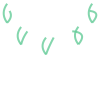

In [78]:
shu.print(curves)

In [ ]:
sh.affinity.scale(shu.print(right_lines+springs_top+springs_bottom+list(upB.geo.geoms)+list(downB.geo.geoms)),100,100)

In [ ]:
sh.line_merge(curves)

In [ ]:
shu.print([segments[0], ])

In [ ]:
print(p.one(0))

In [121]:
def wiggleLine(line):
    line

In [ ]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

a = (0, 0)
b = (10, 0)
c = (9.5, 5)

line = shu.curved_path(a, b, c, curvature=1)
shu.print([line,Point(a),Point(b),Point(c)])

In [ ]:
shu.join(upB,sh.affinity.translate(upB, 0, d*1.5))

In [ ]:
GeometryCollection([shu.Cirºcle(upB.centroid, d/2)]+list(upB_half.geoms))

In [ ]:

square = sh.affinity.translate(shu.Rect(upB.centroid,d/2,d/2).union(shu.Rect(upB.centroid,-d/2,d/2)),0,-d/2)
upB_half = shu.intersection_collection(upB, square)
downB = upB.copy()
square2 = sh.affinity.translate(shu.Rect(downB.centroid,d/2,d/2).union(shu.Rect(downB.centroid,-d/2,d/2)),0,0)
downB_half = shu.intersection_collection(downB, square2)
# crec k vull fer que totes les geometries .rotate .translate .affine_transform existeixin
bottom = sh.affinity.translate(downB_half, 0, -shu.size(downB_half)[1]*3)
GeometryCollection([bottom, upB_half])
all_lines = []
for i,ls in enumerate(bottom.geoms):
    print(upB_half.geoms)
    # print(upB_half.geoms[i].coords[0],ls[0])

In [16]:
v = LineString([[1,0],[1,2]])
hs = [{"line": LineString([[0,(0.5+i)*v.length/5],[2,(0.5+i)*v.length/5]]), "orientation": ((i%2==0)*2)-1} for i in range(5)]

In [ ]:
for h in hs:
    intersection = h['line'].intersection(v)
    h['intersection'] = intersection
hs.sort(key=lambda a: sh.distance(a['intersection'],v.boundary.geoms[0]))
hs

In [ ]:

import numpy as np
current_inline = v.boundary.geoms[0]
curves = []
intensity = 0.5
for i,h in enumerate(hs):
    if (len(hs)>i+1):
        print(h['intersection'],hs[i+1]['intersection'])
        next_inline = LineString([h['intersection'],hs[i+1]['intersection']]).centroid
    else:
        next_inline = v.boundary.geoms[1]
    line = h['line']
    point = h['intersection']

    middle_node = shu.move_point_along_line(point, line, intensity*h['orientation'])
    
    nodes = [list(a) for a in [current_inline.coords[0], middle_node.coords[0], next_inline.coords[0]]]
    # print(nodes)
    # sino transposes es pensa que ed 3d bezier
    curve = bezier.Curve.from_nodes(np.asfortranarray(np.transpose(nodes)))
    # enllaçar curves?
    curves.append(curve)
    current_inline = next_inline

In [ ]:
MultiLineString([shu.curve_to_ls(c) for c in curves]+[v]+[h['line'] for h in hs])